# Git Storage Model - in details (breakdown)

## Description
https://wiki/display/gqd/Git+Storage

gas_storage5

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys
path = os.getcwd()
while not path.endswith('research'):    
    path = os.path.abspath(os.path.join(path, '../'))
sys.path.append(path)

In [3]:
import os, sys
import pandas as pd
import numpy as np
from datetime import datetime, date

In [4]:
#a number of utilities:
from gmt.fom.gas.shared.utils.common import pa
from gmt.fom.gas.shared.utils.dframe import ddff
from gmt.fom.gas.shared.utils.common import flatten_lst

In [5]:
from gmt.fom.gas.shared.models.git_storage.model import GitStorageModel

In [6]:
import cmdty_storage

In [7]:
sys.path.append(r'C:\git\storage-master\samples\python')

In [8]:
import logging

In [9]:
logger = logging.getLogger()

In [10]:
logger.setLevel(logging.INFO)

# Market

so for UK, prices are in pence per therm
which i think we need to conver to pence per kwh 

and then I need to convert stroage capacity into Kwh

from kwh to therms you divide by by 29.3071
from therms to kwh you multiply by 29.3071

## IR

In [11]:
from gmt.fom.gas.shared.models.git_storage.data.ir import Ir

In [12]:
ir = Ir(ccy='GBP')

In [13]:
ir.curve

date
2021-04-15    0.007642
2021-04-16    0.007644
2021-04-17    0.007646
2021-04-18    0.007648
2021-04-19    0.007649
                ...   
2031-03-11    0.017154
2031-03-12    0.017156
2031-03-13    0.017157
2031-03-14    0.017158
2031-03-15    0.017160
Freq: D, Name: rate, Length: 3622, dtype: float64

<AxesSubplot:xlabel='date'>

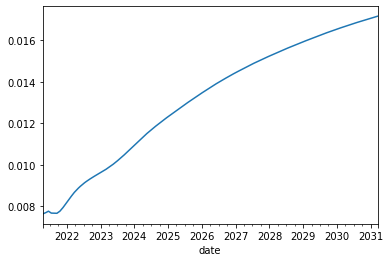

In [14]:
ir.curve.plot()

## Forward

In [15]:
from gmt.fom.gas.shared.models.git_storage.data.fwd import Forward

In [16]:
forward = Forward(ir.ccy, True,True,0.999)

In [17]:
forward.params

{'smooth_curve': True,
 'apply_weekend_shaping': True,
 'weekend_shaping_factor': 0.999,
 'ccy': 'GBP'}

In [ ]:
forward.curve.plot()

# Storage

In [20]:
max_inventory = 4.387e+9 #kwh's
max_injection_rate = 1.82e+8 #kwh's
max_withdrawal_rate = 1.82e+8 #kwh's

In [21]:
from gmt.fom.gas.shared.models.git_storage.storage import Storage

In [22]:
str_type = 'SIMPLE'

if str_type == 'SIMPLE':
    storage = Storage('SIMPLE', 
                  freq='D',
                  storage_start='2021-06-02',
                  storage_end='2022-03-31',
                  injection_cost=0.692359398,
                  withdrawal_cost=0.202930711,
                  #Specific to SIMPLE type:
                  min_inventory=0.0,
                  max_inventory=max_inventory,
                  max_injection_rate=max_injection_rate,
                  max_withdrawal_rate=max_withdrawal_rate,
                  terminal_storage_npv=None #<--- MustBeEmptyAtEnd is True
                     )
else:
    storage = Storage('RATCHETS', 
                  freq='D',
                  storage_start='2021-04-01',
                  storage_end='2022-04-01',
                  injection_cost=0.01,
                  withdrawal_cost=0.025)

In [23]:
storage.params

{'storage_type': <StorageType.SIMPLE: 'SIMPLE'>,
 'freq': 'D',
 'storage_start': '2021-06-02',
 'storage_end': '2022-03-31',
 'injection_cost': 0.692359398,
 'withdrawal_cost': 0.202930711,
 'min_inventory': 0.0,
 'max_inventory': 4387000000.0,
 'max_injection_rate': 182000000.0,
 'max_withdrawal_rate': 182000000.0,
 'terminal_storage_npv': None}

# Diffusion

In [24]:
from gmt.fom.gas.shared.models.git_storage.diffusion import Diffusion

In [25]:
diffusion = Diffusion(
                        spot_mean_reversion=30.0,
                        spot_vol=0.51,
                        long_term_vol=0.31,
                        seasonal_vol=0.2)

In [26]:
diffusion.params

{'spot_mean_reversion': 30.0,
 'spot_vol': 0.51,
 'long_term_vol': 0.31,
 'seasonal_vol': 0.2}

# Calibrator

In [27]:
from gmt.fom.gas.shared.models.git_storage.calibrator import Calibrator

In [28]:
 numerical_tolerance=1e-10

In [29]:
calibrator = Calibrator(
                        num_sims=4000,
                        basis_funcs= '1 + x_st + x_sw + x_lt + s + x_st**2 + x_sw**2 + x_lt**2 + s**2 + s * x_st',
                        seed=11,
                        seed_is_random=False,
                        fwd_sim_seed=13,
                        set_fwd_sim_seed=True,
                        extra_decisions=0,
                        num_inventory_grid_points=100,
                        numerical_tolerance=1e-10)

In [30]:
calibrator.params

{'num_sims': 4000,
 'basis_funcs': '1 + x_st + x_sw + x_lt + s + x_st**2 + x_sw**2 + x_lt**2 + s**2 + s * x_st',
 'seed': 11,
 'seed_is_random': False,
 'fwd_sim_seed': 13,
 'set_fwd_sim_seed': True,
 'extra_decisions': 0,
 'num_inventory_grid_points': 100,
 'numerical_tolerance': 1e-10,
 'settlement_rule': <function gmt.fom.gas.shared.models.git_storage.calibrator.settlement_rule(delivery_date)>}

# Model

In [31]:
from gmt.fom.gas.shared.models.git_storage.model import GitStorageModel

In [32]:
from gmt.fom.gas.shared.models.git_storage.model import *

In [33]:
myModel = GitStorageModel(val_date='2021-06-02',
                          inventory=1500.0,
                          discount_deltas=False,
                          ir = ir,
                          forward=forward,
                          storage=storage, 
                          diffusion=diffusion,
                          calibrator=calibrator
                          )

In [ ]:
myModel.fit()

2021-06-09 09:31:33,081: C:\git\gmt-fom-gas-research\gmt\fom\gas\shared\models\git_storage\model.py: 93: INFO: Fitting....


2021-06-02 2021-06-02
2021-06-03 2021-06-03
2021-06-04 2021-06-04
2021-06-05 2021-06-05
2021-06-06 2021-06-06
2021-06-07 2021-06-07
2021-06-08 2021-06-08
2021-06-09 2021-06-09
2021-06-10 2021-06-10
2021-06-11 2021-06-11
2021-06-12 2021-06-12
2021-06-13 2021-06-13
2021-06-14 2021-06-14
2021-06-15 2021-06-15
2021-06-16 2021-06-16
2021-06-17 2021-06-17
2021-06-18 2021-06-18
2021-06-19 2021-06-19
2021-06-20 2021-06-20
2021-06-21 2021-06-21
2021-06-22 2021-06-22
2021-06-23 2021-06-23
2021-06-24 2021-06-24
2021-06-25 2021-06-25
2021-06-26 2021-06-26
2021-06-27 2021-06-27
2021-06-28 2021-06-28
2021-06-29 2021-06-29
2021-06-30 2021-06-30
2021-07-01 2021-07-01
2021-07-02 2021-07-02
2021-07-03 2021-07-03
2021-07-04 2021-07-04
2021-07-05 2021-07-05
2021-07-06 2021-07-06
2021-07-07 2021-07-07
2021-07-08 2021-07-08
2021-07-09 2021-07-09
2021-07-10 2021-07-10
2021-07-11 2021-07-11
2021-07-12 2021-07-12
2021-07-13 2021-07-13
2021-07-14 2021-07-14
2021-07-15 2021-07-15
2021-07-16 2021-07-16
2021-07-17

In [ ]:
myModel.plot(batch_mode=False)


In [ ]:
myModel.save_results()

In [ ]:
myModel.email_results()

# Retrieve job results

In [ ]:
t_range = myModel.data_adapter.results_t_range; t_range

In [ ]:
myModel.data_adapter.load_uk1(t_range)

In [ ]:
query = dict(run_date=pd.to_datetime(t_range[1]))
df = myModel.data_adapter.load_uk1(query=query)

In [ ]:
df